# Setup

In [2]:
# === Standard Library ===
import os
import sys
import copy
import h5py

# === Scientific Computing ===
import numpy as np
from sklearn.mixture import GaussianMixture

# === Torch & TorchVision ===
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torchvision.utils import (
    draw_segmentation_masks,
    draw_bounding_boxes,
    make_grid
)

# === PIL & Plotting ===
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# === Progress Bar ===
from tqdm import tqdm

# === CRP & Zennit ===
import zennit.image as zimage
from crp.image import imgify
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names

# === LCRP Utilities ===
from LCRP.models import get_model
from LCRP.utils.crp_configs import ATTRIBUTORS, CANONIZERS, VISUALIZATIONS, COMPOSITES

# === Local Project Modules ===
sys.path.append("..")  # Temporary path extension for imports

#from src.minio_client import MinIOClient
from src.glocal_analysis import run_analysis 
from src.datasets.person_car_dataset import PersonCarDataset
from src.plot_pcx_explanations_YOLO import plot_pcx_explanations

ADDING vgg
ADDING mobilenet_v2
ADDING efficient_net-b3
ADDING mobilenet_v3
ADDING SSDBoxPredictor
ADDING SSDLiteBoxPredictor
ADDING SSDBoxHead


In [3]:
# Define transformation (if needed)
dtype = torch.float32
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Resize((1280, 1280)),
    transforms.Lambda(lambda x: x.to(dtype)), 
])

# Load dataset
root_dir = "../datasets/data/person_car_detection_data/Arthal"
dataset = PersonCarDataset(root_dir=root_dir, split="train", transform=transform)

model_name = "yolov6s6"
output_dir_crp = "output/crp/yolo_person_car/"

# Loading unet with path to checkpoint
ckpt_path = "../models/best_v6s6_ckpt.pt"
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cuda:1"
model = get_model(model_name=model_name, classes=2, ckpt_path=ckpt_path, device=device, dtype=dtype)
model.to(device);


# Running and saving attributions of our dataset per layer
You don't need to run it if PCX results are already saved!!!

In [4]:
# dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=8)
# cc = ChannelConcept()
# class_id = 0
#
# layer_names = get_layer_names(model, [torch.nn.Conv2d])
# layer_names.remove("module.detect.proj_conv")
#
# # Setting up CRP 
# attribution = ATTRIBUTORS[model_name](model)
# composite = COMPOSITES[model_name](canonizers=[CANONIZERS[model_name]()])
# condition = [{"y": class_id}]    
# fv = VISUALIZATIONS[model_name](
#     attribution,
#     dataset,
#     layer_names,
#     preprocess_fn=lambda x: x,
#     path=output_dir_crp,
#     max_target="max"
# )
#
# start = datetime.now()
#
# # Prepare per-layer buffers
# activations = {ln: [] for ln in layer_names}
# attributions = {ln: [] for ln in layer_names}
#
# for i, (x, y) in enumerate(tqdm(dataset)):
#     print(f"\n------ Sample {i} --------")
#     x = x.to(device).requires_grad_()
#     cond = [{"y": class_id}]
#     
#     # Compute attributions and record layer activations/relevances
#     attr = attribution(x.unsqueeze(0), cond, composite, record_layer=layer_names)
#
#     for ln in layer_names:
#         print(f"\n--------- Layer: {ln} -----------")
#
#         # Collect per-layer
#         activations[ln].append(attr.activations[ln].amax(dim=(-2, -1)))
#         attributions[ln].append(cc.attribute(attr.relevances[ln], abs_norm=True))
#
# # Now concatenate and save **per** layer
# for ln in layer_names:
#     folder = os.path.join("output/pcx/yolo_person_car", ln)
#     fn_a  = os.path.join(folder, f"activations_{class_id}.npy")
#     fn_r  = os.path.join(folder, f"attributions_{class_id}.npy")
#
#     os.makedirs(folder, exist_ok=True)
#
#     act_tensor = torch.cat(activations[ln]).cpu().numpy()
#     rel_tensor = torch.cat(attributions[ln]).cpu().numpy()
#
#     # Save to .npy files
#     np.save(fn_a, act_tensor)
#     np.save(fn_r, rel_tensor)
#
# end = datetime.now()
# print(f"elapsed: {end - start}")

# Fitting GMM - Clustering Attributions

Here for each layer we can fit an GMM and check how many components we want for cluster

2025-05-09 17:09:45.357273: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746803385.364968 1468943 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746803385.368315 1468943 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-09 17:09:45.381173: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/said/.virtualenvs/UNET/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading lay

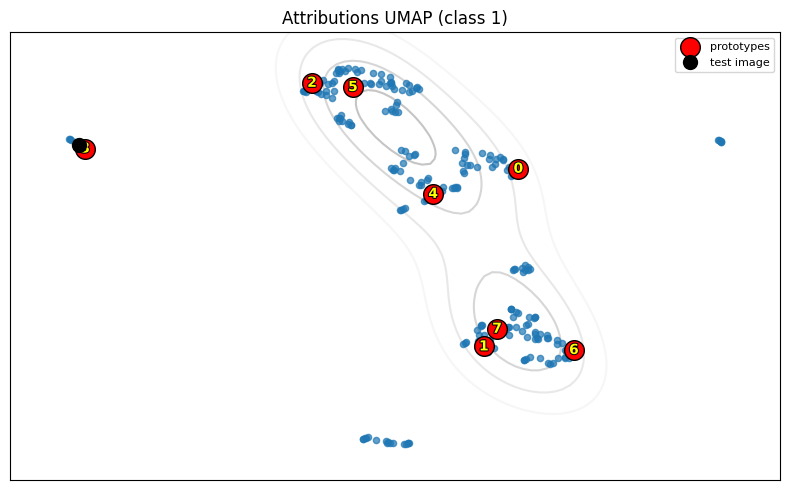

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.mixture import GaussianMixture
from scipy import stats
import torch
import matplotlib.patheffects as pe

# ─── Parameters ───
class_ids    = [1]
layer_name   = 'module.backbone.ERBlock_2.1.conv1.rbr_1x1.conv'
base_folder  = f"output/pcx/yolo_person_car/{layer_name}/"
n_prototypes_class_0    = 2
n_prototypes_class_1    = 8
n_prototypes_classes = { 0: n_prototypes_class_0, 
                         1: n_prototypes_class_1}
test_idx = 14

# Prepare prototype containers per class
prototypes = {cls: [] for cls in class_ids}

fig, axes = plt.subplots(
    nrows=len(class_ids),
    ncols=1,
    figsize=(8, 5 * len(class_ids)),
    facecolor='white',
    squeeze=False
)

for row, cls in enumerate(class_ids):
    # Load only attributions
    attrib_path = os.path.join(base_folder, f"attributions_{cls}.npy")
    attributions = np.load(attrib_path)

    if isinstance(attributions, torch.Tensor):
        attributions = attributions.detach().cpu().numpy()

    # UMAP on attributions
    umap_attr = UMAP(n_neighbors=5, random_state=123, n_jobs=1)
    embedding = umap_attr.fit_transform(attributions)
    x, y = embedding[:, 0], embedding[:, 1]

    # Create a grid for KDE contours
    xmin, xmax = x.min() - 2, x.max() + 2
    ymin, ymax = y.min() - 2, y.max() + 2
    Xgrid, Ygrid = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([Xgrid.ravel(), Ygrid.ravel()])
    values    = np.vstack([x, y])
    kernel    = stats.gaussian_kde(values, bw_method=0.5)
    Z         = np.reshape(kernel(positions).T, Xgrid.shape).T

    ax = axes[row, 0]
    # Plot KDE contours
    ax.contour(
        Z,
        extent=[xmin, xmax, ymin, ymax],
        cmap='Greys',
        alpha=0.3,
        extend='min',
        zorder=0
    )
    # Scatter the embedding points
    ax.scatter(x, y, s=20, alpha=0.7, zorder=1)

    # Fit GMM on the original attribution vectors
    n_proto = n_prototypes_classes[cls]
    gmm = GaussianMixture(n_components=n_proto, random_state=0)
    gmm.fit(attributions)
    prototypes[cls].append(gmm.means_)

    # Project the GMM means into UMAP space
    proto_2d = umap_attr.transform(gmm.means_)
    ax.scatter(
        proto_2d[:, 0],
        proto_2d[:, 1],
        s=200,
        facecolor='red',
        edgecolor='k',
        linewidth=1,
        zorder=3,
        label='prototypes'
    )

    # Annotate prototype indices
    for k, (px, py) in enumerate(proto_2d):
        ax.text(
            px, py, str(k),
            fontsize=10,
            fontweight='bold',
            color='#ffff00',
            ha='center', va='center',
            zorder=4,
            path_effects=[pe.withStroke(linewidth=1.5, foreground='black')]
        )

    # Highlight the test sample
    tx, ty = embedding[test_idx]
    ax.plot(
        tx, ty,
        'ko',
        markersize=10,
        label='test image',
        zorder=5
    )

    ax.set_title(f"Attributions UMAP (class {cls})")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()


## Plot Protoypes with concepts

torch.Size([33, 8])
torch.Size([33, 8])
torch.Size([13, 8])
torch.Size([13, 8])
torch.Size([43, 8])
torch.Size([43, 8])
torch.Size([5, 8])
torch.Size([5, 8])
torch.Size([40, 8])
torch.Size([40, 8])
torch.Size([26, 8])
torch.Size([26, 8])
torch.Size([14, 8])
torch.Size([14, 8])
torch.Size([40, 8])
torch.Size([40, 8])
torch.Size([6, 8])
torch.Size([6, 8])
torch.Size([7, 8])
torch.Size([7, 8])
torch.Size([6, 8])
torch.Size([6, 8])
torch.Size([11, 8])
torch.Size([11, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([3, 8])
torch.Size([3, 8])
torch.Size([4, 8])
torch.Size([4, 8])
torch.Size([6, 8])
torch.Size([6, 8])
torch.Size([61, 8])
torch.Size([61, 8])
torch.Size([44, 8])
torch.Size([44, 8])
torch.Size([41, 8])
torch.Size([41, 8])
torch.Size([41, 8])
torch.Size([41, 8])
torch.Size([5, 8])
torch.Size([5, 8])
torch.Size([56, 8])
torch.Size([56, 8])
torch.Size([47, 8])
torch.Size([47, 8])
torch.Size([54, 8])
torch.Size([54, 8])
torch.Size([32, 8])
torch.Size([32, 8])
torch.Size([31, 8]

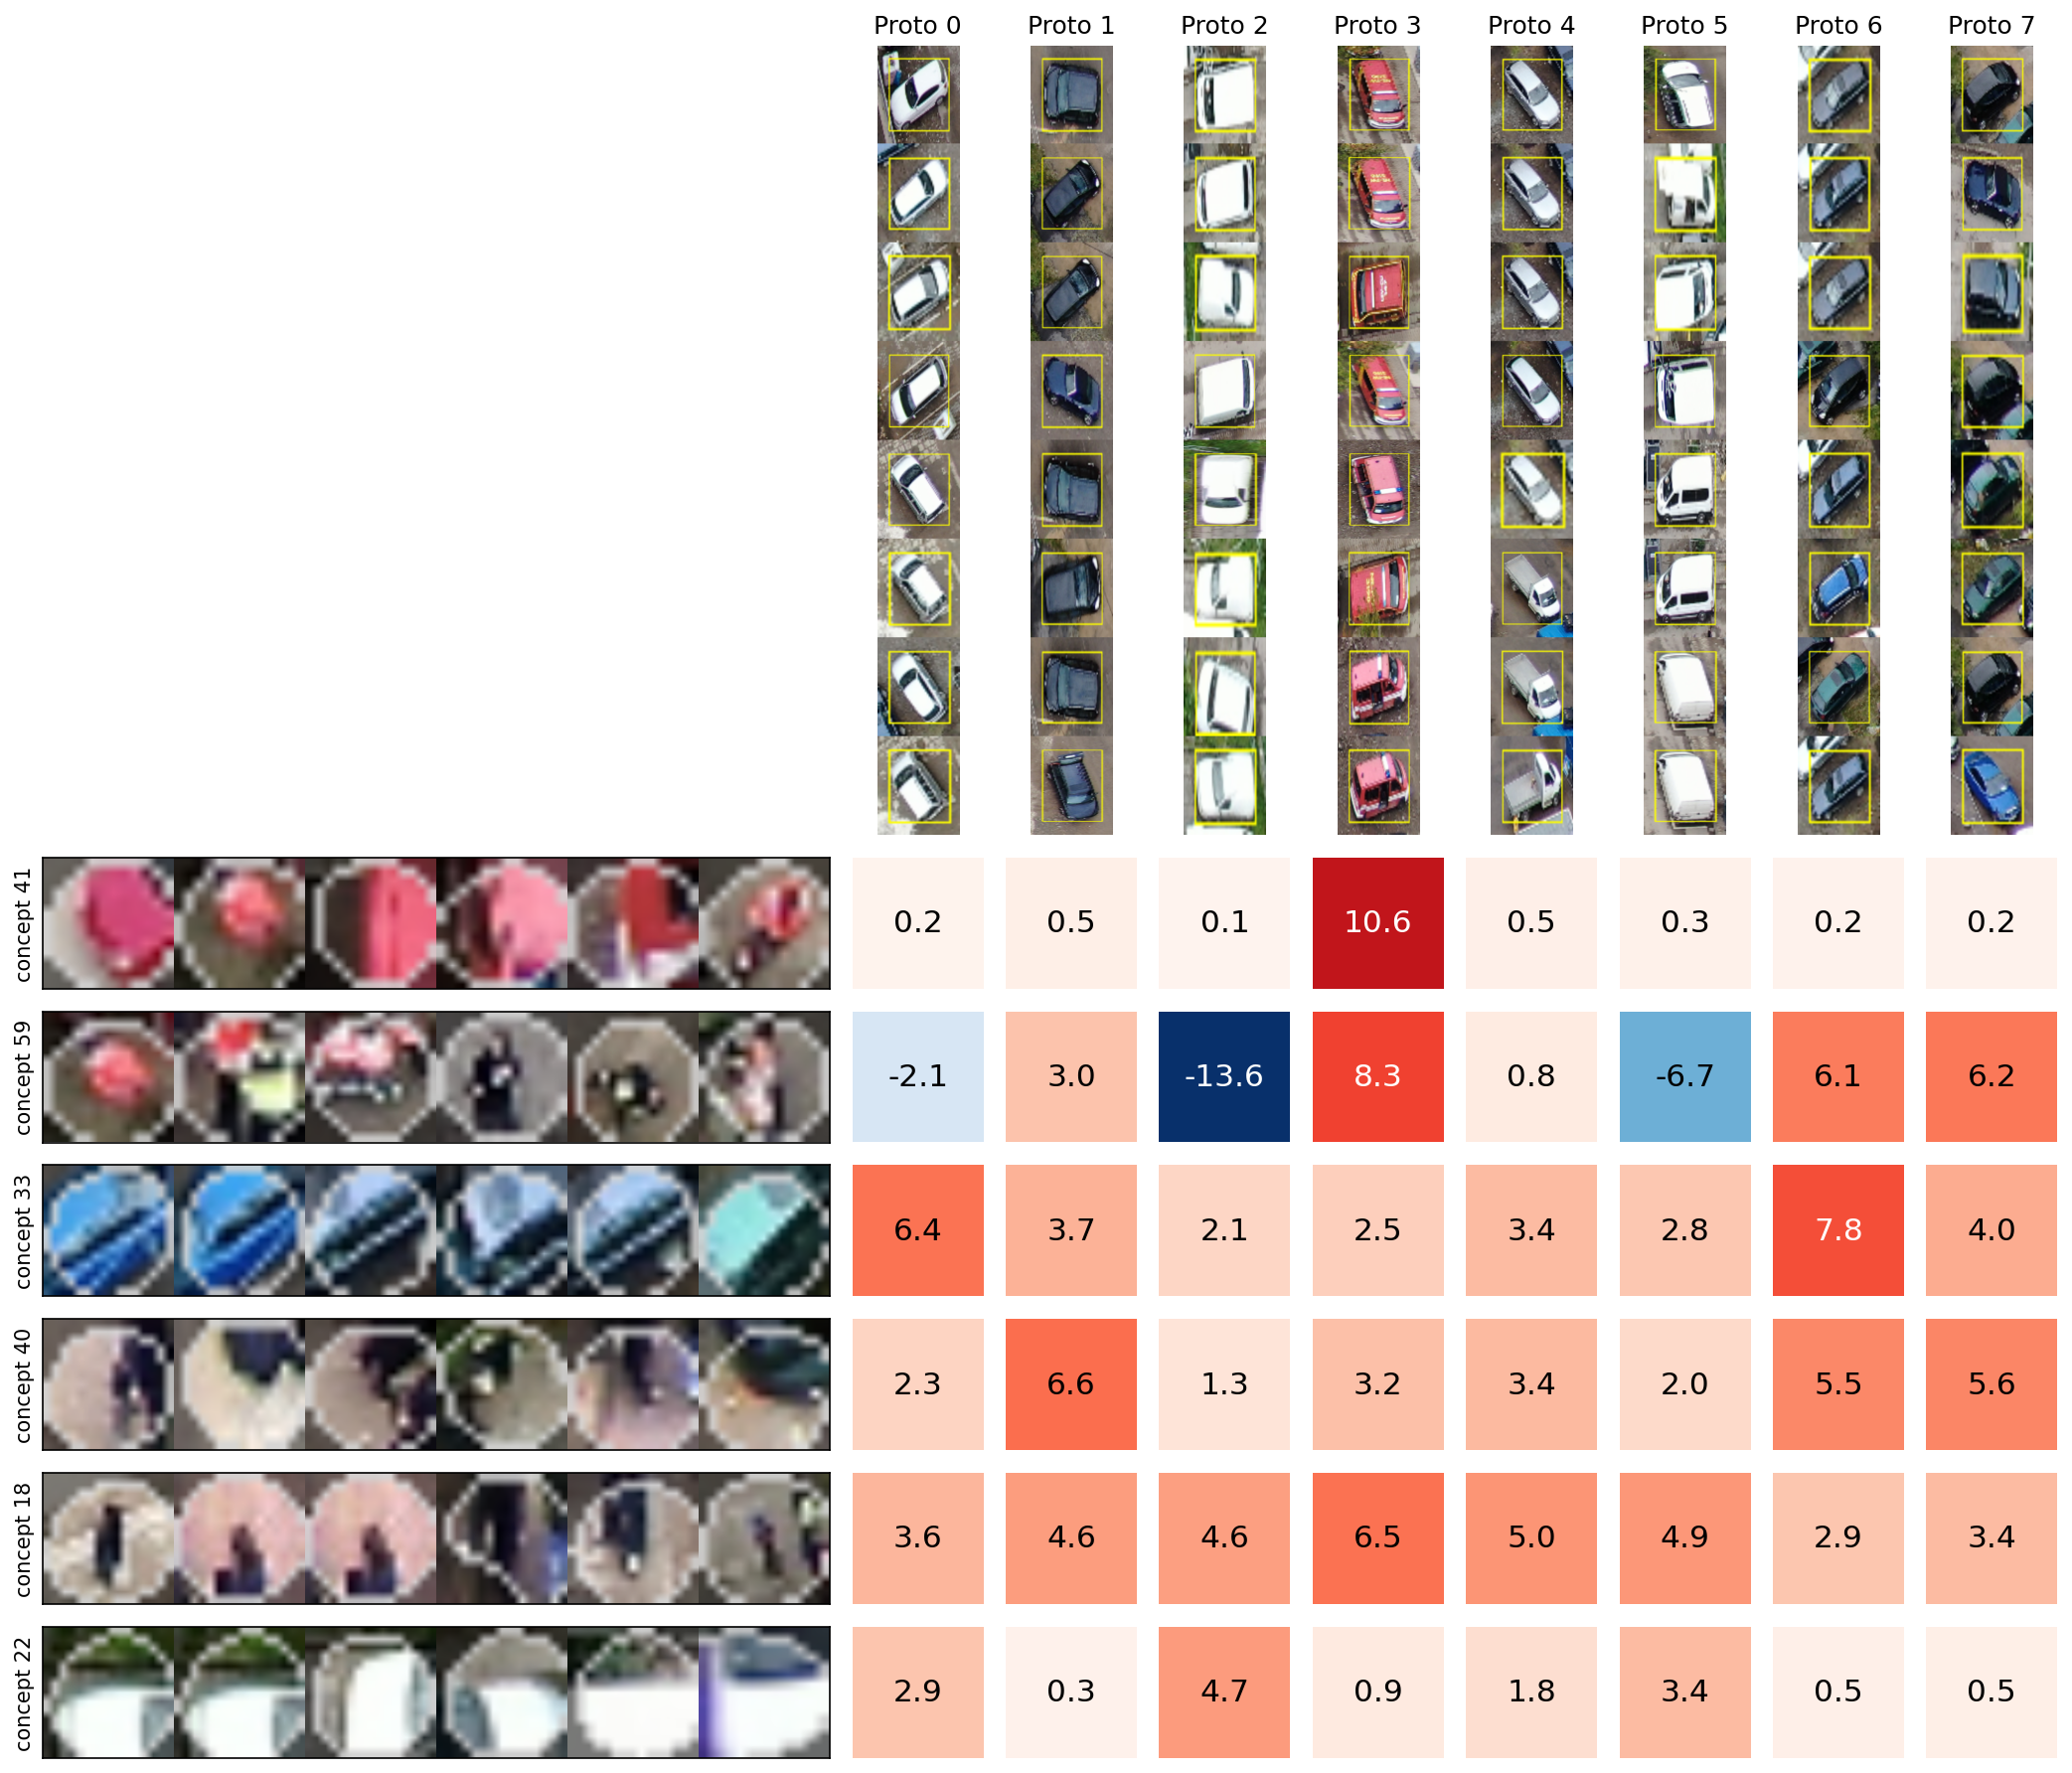

In [6]:
from LCRP.utils.render import vis_opaque_img_border
import numpy as np
import torch
import torchvision.utils
import torchvision.transforms.functional as TF
from PIL import ImageDraw


def get_ref_images(fv, topk_ind, layer_name, composite, class_id,batch_size,  n_ref=6, ref_imgs_save_path="output/ref_imgs/"):
    ref_imgs_save_path = os.path.join(ref_imgs_save_path, f"{layer_name}_class_{class_id}.h5")
    os.makedirs(os.path.dirname(ref_imgs_save_path), exist_ok=True)

    ref_imgs = {}
    missing_keys = list(map(str, topk_ind))

    if os.path.exists(ref_imgs_save_path):
        with h5py.File(ref_imgs_save_path, "a") as f:
            existing_keys = set(f.keys())
            missing_keys = [str(k) for k in topk_ind if str(k) not in existing_keys]

            for k in topk_ind:
                str_k = str(k)
                if str_k in f:
                    group = f[str_k]
                    ref_imgs[int(str_k)] = [Image.fromarray(group[str(idx)][:]) for idx in
                                            sorted(group.keys(), key=int)]

            if missing_keys:
                print(f"Calculating and saving missing reference images for keys: {missing_keys}")
                new_refs = fv.get_max_reference([int(k) for k in missing_keys], layer_name, "relevance", (0, n_ref),
                                                composite=composite, rf=True, plot_fn=vis_opaque_img_border)
                for key, images_list in new_refs.items():
                    group = f.create_group(str(key))
                    assert len(images_list) >= n_ref
                    ref_imgs[key] = []
                    for idx, image in enumerate(images_list[:n_ref]):
                        if isinstance(image, Image.Image):
                            arr = np.array(image)
                            group.create_dataset(str(idx), data=arr)
                            ref_imgs[key].append(image)
                        else:
                            print(f"Warning: Item '{idx}' in key '{key}' is not a PIL image and will not be saved.")
    else:
        print("Reference image file does not exist, calculating all.")
        ref_imgs = fv.get_max_reference(topk_ind, layer_name, "relevance", (0, n_ref),
                                        composite=composite, rf=True, plot_fn=vis_opaque_img_border, batch_size=batch_size)
        with h5py.File(ref_imgs_save_path, "w") as f:
            for key, images_list in ref_imgs.items():
                group = f.create_group(str(key))
                assert len(images_list) >= n_ref
                for idx, image in enumerate(images_list[:n_ref]):
                    if isinstance(image, Image.Image):
                        arr = np.array(image)
                        group.create_dataset(str(idx), data=arr)
                    else:
                        print(f"Warning: Item '{idx}' in key '{key}' is not a PIL image and will not be saved.")

    return ref_imgs

def get_cropped_box(idx):
    # 1) fetch image & run attribution for the box
    img_tensor, _ = dataset[idx]
    img_tensor = img_tensor.to(device)
    data_p = img_tensor.unsqueeze(0).requires_grad_()
    attribution.take_prediction = 0
    attr = attribution(
        data_p, [{"y": class_id}],
        composite,
        record_layer=[layer_name],
        init_rel=1
    )

    # 2) get boxes & filter by class
    boxes = model.predict_with_boxes(data_p)[1][0]
    preds = attr.prediction[0]
    order = preds.max(dim=1)[0].argsort(descending=True)
    filtered = [
        b for b,c in zip(boxes[order], preds.argmax(dim=1)[order])
        if c.item()==class_id
    ]
    x1,y1,x2,y2 = map(int, filtered[0].cpu().tolist())

    # 3) reverse‐normalize → uint8 PIL
    rn = dataset.reverse_normalization(img_tensor).clamp(0,255).byte()
    pil_img = TF.to_pil_image(rn)

    # 4) inflate box by margin_ratio
    w,h = x2-x1, y2-y1
    mx,my = int(w*0.2), int(h*0.2)
    bx1,by1 = max(0,x1-mx), max(0,y1-my)
    bx2 = min(pil_img.width,  x2+mx)
    by2 = min(pil_img.height, y2+my)

    # 5) crop & draw outline
    crop = pil_img.crop((bx1,by1,bx2,by2))
    draw = ImageDraw.Draw(crop)
    draw.rectangle([(mx,my),(mx+w,my+h)], outline="yellow", width=1)

    # 6) to float‐tensor in [0,1]
    arr = np.array(crop)  # H×W×3 uint8
    t = torch.from_numpy(arr).permute(2,0,1).float().div(255.0)
    return t

# --- user‐tunable parameters ---
num_samples   = 8       # how many images per prototype
class_id = 1

if class_id == 0:
    N_PROTOTYPES = n_prototypes_class_0
else:
    N_PROTOTYPES = n_prototypes_class_1
    
    
proto = torch.from_numpy(np.array(prototypes[cls]))

top_concepts = torch.topk(proto, 1).indices.flatten().unique()
# take the relevances
proto = proto[0] 

top_concepts = top_concepts[proto[:, top_concepts].amax(0).argsort(descending=True)].tolist()
concept_matrix = proto[:, top_concepts].T
N_CONCEPTS = len(top_concepts)

layer_names = get_layer_names(model, [torch.nn.Conv2d])

# Setting up CRP 
attribution = ATTRIBUTORS[model_name](model)
composite = COMPOSITES[model_name](canonizers=[CANONIZERS[model_name]()])
condition = [{"y": class_id}]    
fv = VISUALIZATIONS[model_name](attribution,
                                    dataset,
                                    layer_names,
                                    preprocess_fn=lambda x: x,
                                    path=output_dir_crp,
                                    max_target="max")

ref_imgs = get_ref_images(fv, top_concepts, layer_name, composite=composite, class_id=class_id, n_ref=6, ref_imgs_save_path="output/ref_imgs_6/", batch_size=1)

# --- distances, ranking, top‐k ---
prot_arr = np.array(prototypes[class_id][0])
distances   = np.linalg.norm(attributions[:,None,:] - prot_arr[None,:,:], axis=2)
ranked_idxs = np.argsort(distances, axis=0)
num_samples = min(num_samples, ranked_idxs.shape[0])
top_idxs    = ranked_idxs[:num_samples, :] 

all_crops = [
    [ get_cropped_box(int(idx)) for idx in top_idxs[:, pj] ]
    for pj in range(N_PROTOTYPES)
]

heights = [t.shape[1] for col in all_crops for t in col]
widths  = [t.shape[2] for col in all_crops for t in col]
target_h, target_w = max(heights), max(widths)

all_resized = [
    [ TF.resize(t, (target_h, target_w)) for t in col ]
    for col in all_crops
]

fig, axs = plt.subplots(
    nrows=N_CONCEPTS + 1,
    ncols=N_PROTOTYPES + 1,
    figsize=(N_PROTOTYPES + 6, N_CONCEPTS + 6),
    dpi=150,
    gridspec_kw={
        'width_ratios': [6] + [1]*N_PROTOTYPES,
        'height_ratios': [6] + [1]*N_CONCEPTS
    }
)

for i in range(N_CONCEPTS):
    for j in range(N_PROTOTYPES):
        val = concept_matrix[i, j].item()
        axs[i + 1, j + 1].matshow(np.ones((1, 1)) * val if val >= 0 else np.ones((1, 1)) * val * -1,
                                  vmin=0,
                                  vmax=concept_matrix.abs().max(),
                                  cmap="Reds" if val >= 0 else "Blues")
        minmax = concept_matrix.abs().max() * 100 / 2
        cos = val * 100
        color = "white" if abs(cos) > minmax else "black"
        axs[i + 1, j + 1].text(0, 0, f"{cos:.1f}", ha="center", va="center", color=color, fontsize=15)
        axs[i + 1, j + 1].axis('off')
resize = torchvision.transforms.Resize((120, 120))


for pj in range(N_PROTOTYPES):
    
    grid = torchvision.utils.make_grid(
        all_resized[pj],
        nrow=1,
        padding=0
    )
    arr = np.array(zimage.imgify(grid.cpu()))
    axs[0, pj+1].imshow(arr)
    axs[0, pj+1].set_title(f"Proto {pj}", fontsize=12)
    axs[0, pj+1].axis('off')

axs[0,0].axis('off')


for i in range(N_CONCEPTS):
    grid = make_grid(
        [resize(TF.to_tensor(i)) for i in ref_imgs[top_concepts[i]]],
        # [resize(torch.from_numpy(np.asarray(i)).permute((0, 1, 2))) for i in ref_imgs[topk_ind[i]]],
        nrow=int(6 / 1),
        padding=0)
    grid = np.array(zimage.imgify(grid.detach().cpu()), copy=True)

    axs[i + 1, 0].imshow(grid)
    axs[i + 1, 0].set_ylabel(f"concept {top_concepts[i]}")
    axs[i + 1, 0].set_yticks([])
    axs[i + 1, 0].set_xticks([])

plt.tight_layout()
save_path = f"output/pcx/proto_with_concepts/{layer_name}_class{class_id}.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=150, bbox_inches="tight")
print(f"➡️ Figure saved to: {save_path}")
plt.show()

## Calculate Local XAI time

In [7]:
import logging
from datetime import datetime

n_prototypes_by_layer = { 'module.backbone.ERBlock_3.1.block.1.rbr_1x1.conv': {0: 4, 1: 6}}
layer_names = list(n_prototypes_by_layer.keys())

# 1) SETUP LOGGER
logger = logging.getLogger()            
logger.setLevel(logging.DEBUG)
if logger.hasHandlers():
    logger.handlers.clear()

file_handler = logging.FileHandler(f'debug_log_yolo_{layer_names[0]}.txt')
file_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s:%(name)s:%(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

attribution = ATTRIBUTORS[model_name](model)
composite   = COMPOSITES[model_name](canonizers=[CANONIZERS[model_name]()])

# 3) RUN ATTRIBUTIONS (100 samples per class & layer)
start_all = datetime.now()
class_id = 1
print(f"\n== Class {class_id} ==")
for layer in layer_names:
    print(f"  → Layer: {layer}")
    for i in range(100):
        img, _ = dataset[i]
        print(f"------ sample: {i} ----------")
        img = img.unsqueeze(0).to(device).requires_grad_()
        _ = attribution(img, [{"y": class_id}], composite, record_layer=[layer], init_rel=1)

end_all = datetime.now()
print(f"\nTotal attribution run time: {end_all - start_all}")


== Class 1 ==
  → Layer: module.backbone.ERBlock_3.1.block.1.rbr_1x1.conv
------ sample: 0 ----------
torch.Size([33, 8])
------ sample: 1 ----------
torch.Size([48, 8])
------ sample: 2 ----------
torch.Size([34, 8])
------ sample: 3 ----------
torch.Size([37, 8])
------ sample: 4 ----------
torch.Size([30, 8])
------ sample: 5 ----------
torch.Size([51, 8])
------ sample: 6 ----------
torch.Size([31, 8])
------ sample: 7 ----------
torch.Size([6, 8])
------ sample: 8 ----------
torch.Size([32, 8])
------ sample: 9 ----------
torch.Size([52, 8])
------ sample: 10 ----------
torch.Size([58, 8])
------ sample: 11 ----------
torch.Size([9, 8])
------ sample: 12 ----------
torch.Size([27, 8])
------ sample: 13 ----------
torch.Size([14, 8])
------ sample: 14 ----------
torch.Size([40, 8])
------ sample: 15 ----------
torch.Size([5, 8])
------ sample: 16 ----------
torch.Size([37, 8])
------ sample: 17 ----------
torch.Size([42, 8])
------ sample: 18 ----------
torch.Size([5, 8])
------ s

In [8]:
import re
import numpy as np

# 4) PARSE LOG AND COMPUTE AVERAGES
ratios = []
pred_times = []
back_times = []
full_times = []

n_prototypes_by_layer = { 'module.backbone.ERBlock_3.1.block.1.rbr_1x1.conv': {0: 4, 1: 6}}
layer_names = list(n_prototypes_by_layer.keys())

with open(f'debug_log_yolo_{layer_names[0]}.txt', 'r') as f:
    for line in f:
        if 'Prediction time' in line:
            m = re.search(
                r'Prediction time: ([\d\.]+), Backward time: ([\d\.]+), Full attribution time: ([\d\.]+)',
                line
            )
            if not m:
                continue
            pt = float(m.group(1))
            bt = float(m.group(2))
            ft = float(m.group(3))
            pred_times.append(pt)
            back_times.append(bt)
            full_times.append(ft)
            if pt > 0:
                ratios.append(bt / pt)

if ratios:
    avg_ratio = sum(ratios) / len(ratios)
    print(f"\nAverage (Backward/Prediction) ratio: {avg_ratio:.4f}")
    print(f"Avg prediction time: {np.mean(pred_times):.4f}s")
    print(f"Avg backward   time: {np.mean(back_times):.4f}s")
    print(f"Avg full attrib time: {np.mean(full_times):.4f}s")
else:
    print("No timing entries found in log.")



Average (Backward/Prediction) ratio: 5.4444
Avg prediction time: 0.0555s
Avg backward   time: 0.2680s
Avg full attrib time: 0.2718s


## PCX explanations Visualisation

🔄 Sample 11 → layer `module.backbone.ERBlock_3.0.rbr_dense.conv` (prototypes=5)
torch.Size([9, 8])
torch.Size([9, 8])
torch.Size([44, 8])
torch.Size([9, 8])
torch.Size([44, 8])
torch.Size([44, 8])


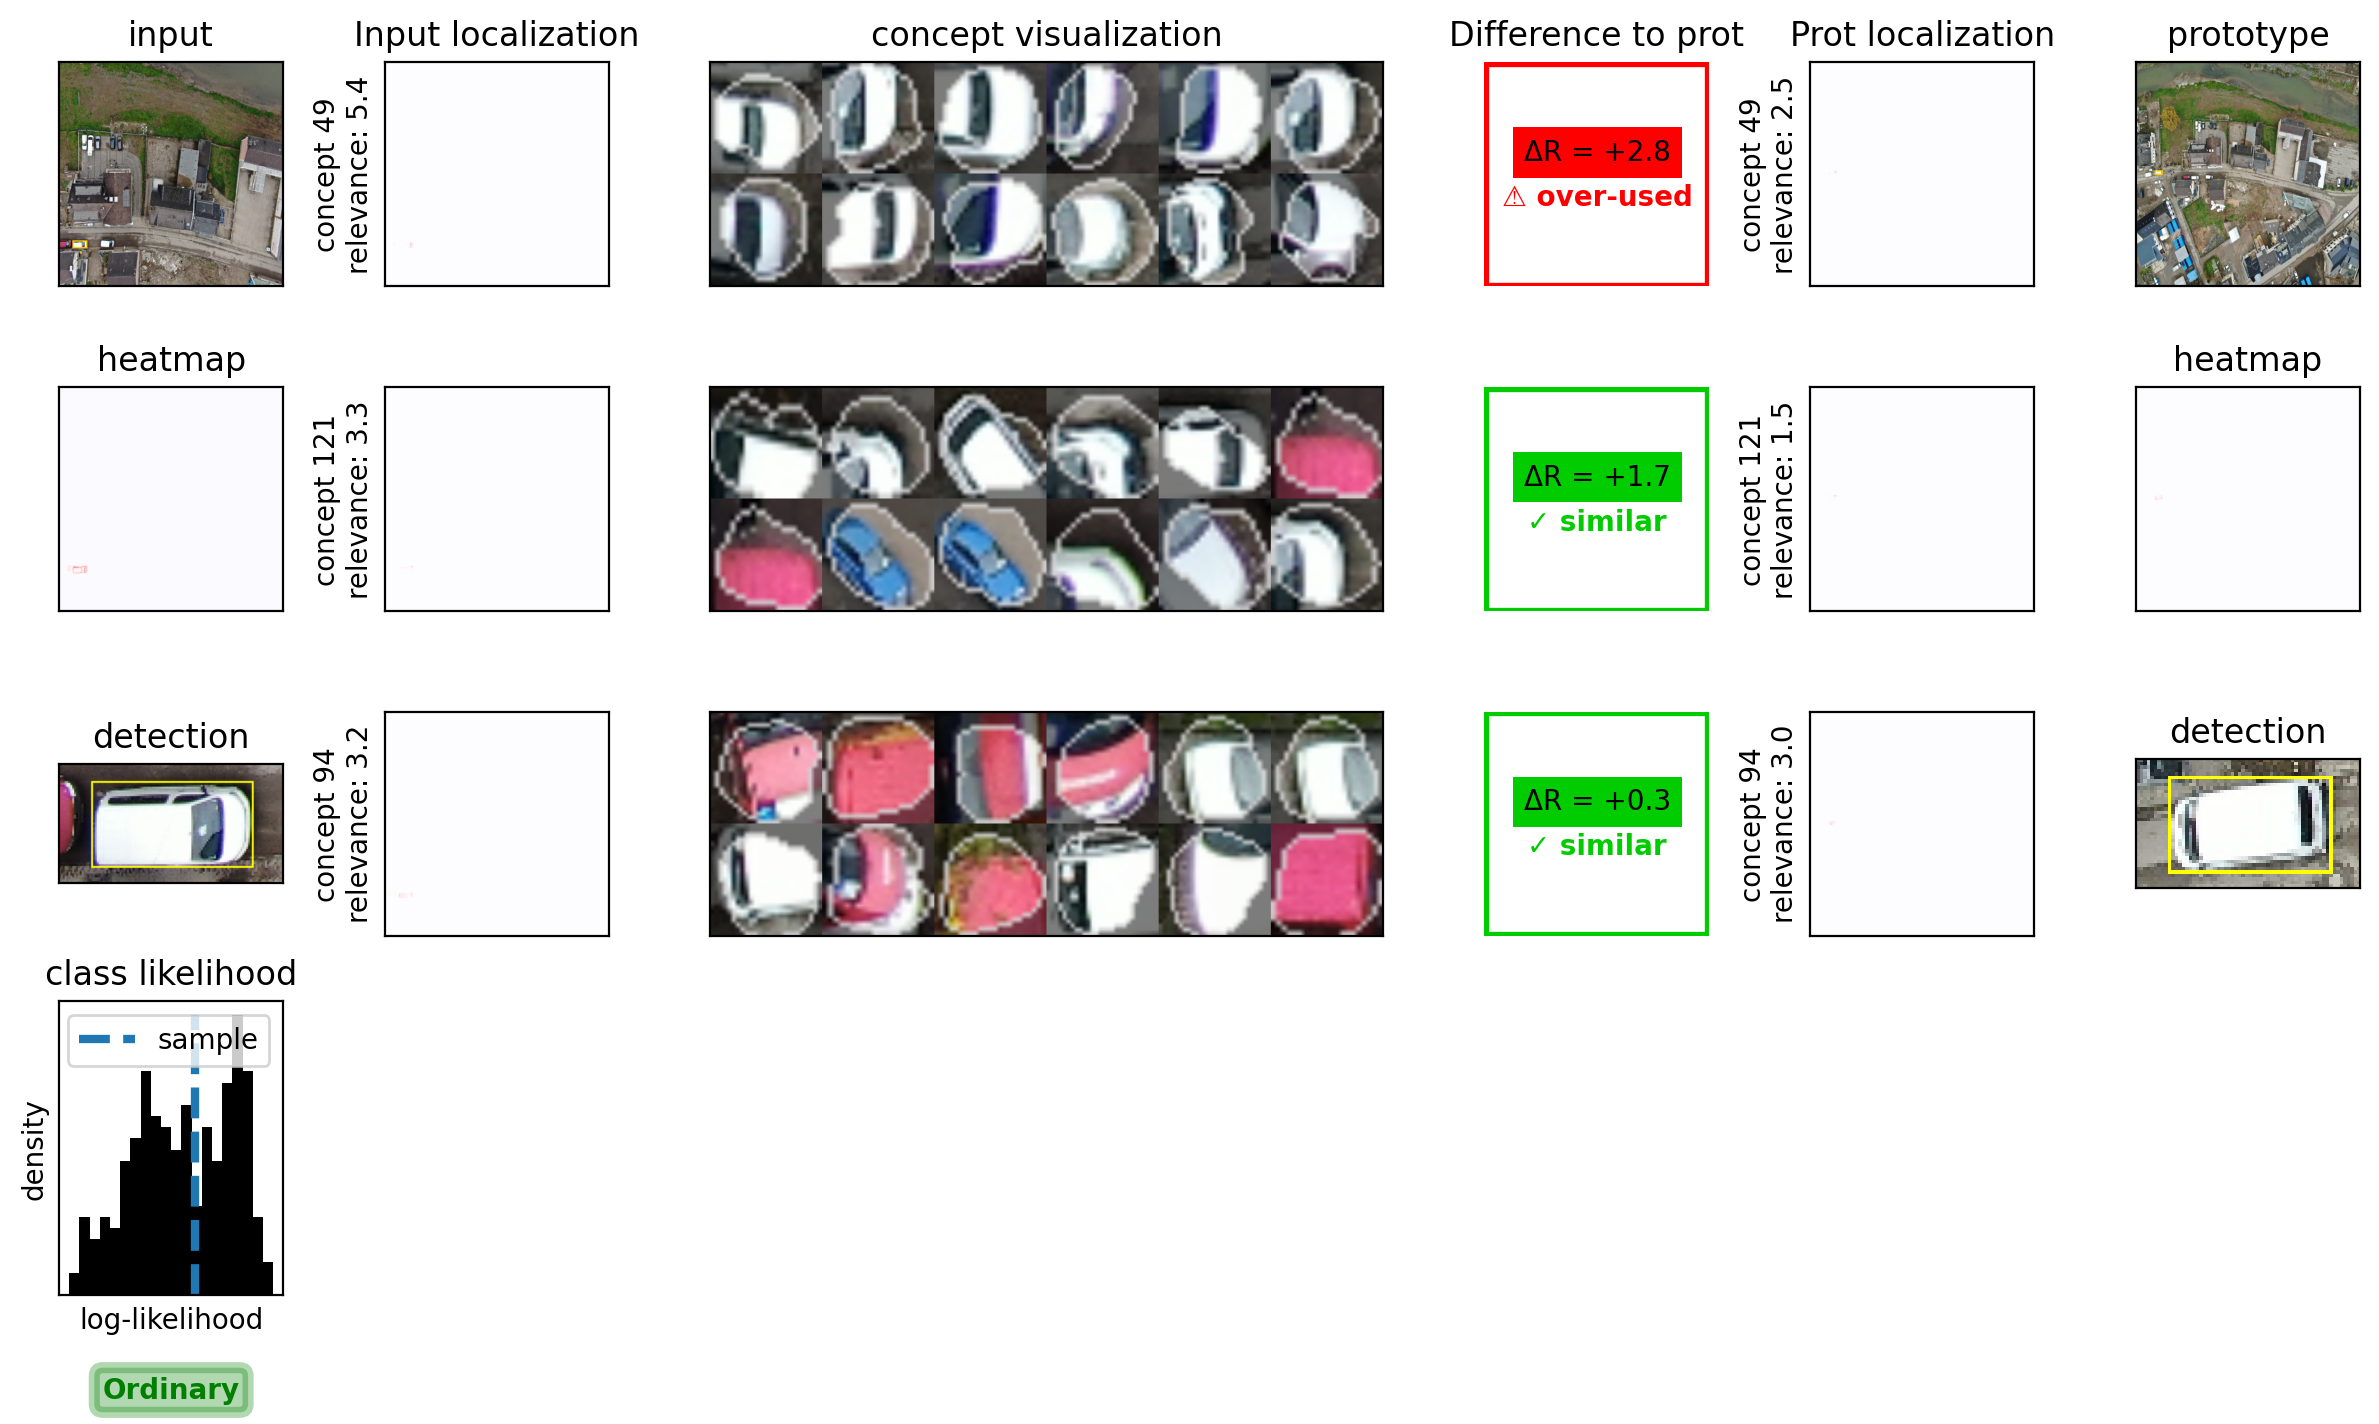

In [ ]:
n_prototypes_by_layer = {
    'module.backbone.ERBlock_3.0.rbr_dense.conv': {0: 4, 1: 5}}
layer_names = list(n_prototypes_by_layer.keys())

class_id    = 1
sample_ids  = [11]


for sample_id in sample_ids:
    for layer_name, proto_dict in n_prototypes_by_layer.items():
        n_protos = proto_dict[class_id]
        print(f"🔄 Sample {sample_id} → layer `{layer_name}` (prototypes={n_protos})")
        try:
            plot_pcx_explanations(
                class_id        = class_id,
                model_name      = model_name,
                model           = model,
                dataset         = dataset,
                sample_id       = sample_id,
                n_concepts      = 3,
                n_refimgs       = 12,
                num_prototypes  = proto_dict,
                
                layer_name      = layer_name,
                ref_imgs_path   = "output/ref_imgs_12/",
                output_dir_pcx  = "output/pcx/yolo_person_car",
                output_dir_crp  = output_dir_crp
            )
        except Exception as e:
            print(f"❌ Failed on sample {sample_id}, layer {layer_name}: {e}")
